In [70]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
# from models import DailyStats
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import datetime


from sklearn.pipeline         import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OneHotEncoder, OrdinalEncoder
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import Huber

from feature_engineering import _prepare_training_frame, drop_outliers
from pipeline import _build_pipeline




load_dotenv()  # reads .env in working directory
db_url = os.getenv("DATABASE_URL")
db_url = "postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et"
print(db_url)
# Heroku uses postgres:// but SQLAlchemy expects postgresql://
if db_url.startswith("postgres://"):
    db_url = db_url.replace("postgres://", "postgresql://", 1)

engine = create_engine(db_url)

postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et


In [74]:
# now read and print
df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)

# now read and print
df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

# — prep the frame and feature list
df_clean, features, hist_cols = _prepare_training_frame(df_daily)
df_clean = df_clean.sort_values(['stream_name', 'stream_date'])
df_clean = drop_outliers(df_clean, cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'] ,method='iqr', factor=25.0)

full_pipe, model_type = _build_pipeline(df_clean[features])
pre: pd.DataFrame  = full_pipe.named_steps['pre']

# X_all = pre.fit_transform(df_clean[features])

# # Optionally grab the transformed feature names
# try:
#     feature_names = pre.get_feature_names_out()
# except:
#     feature_names = [f"f{i}" for i in range(X_all.shape[1])]

# # — build sliding‐window sequences of length `timesteps`
# timesteps = 10
# seqs, targets = [], []

# # we’ll use total_subscriptions as the example target
# y_all = df_clean['total_subscriptions'].values

# 0) sort and reset index so positions == labels
df_sorted = df_clean.sort_values(['stream_name','stream_date']).reset_index(drop=True)

# 1) per-streamer split point (80% of each streamer's history)
split_points = {name: int(0.8*len(g)) for name, g in df_sorted.groupby('stream_name', sort=False)}

# 2) train/test masks at the ROW level
row_is_train = np.zeros(len(df_sorted), dtype=bool)
for name, g in df_sorted.groupby('stream_name', sort=False):
    ntr = split_points[name]
    row_is_train[g.index[:ntr]] = True

# 3) fit preprocessor on TRAIN ONLY, then transform all
pre = full_pipe.named_steps['pre']
pre.fit(df_sorted.loc[row_is_train, features])
X_all = pre.transform(df_sorted[features]).astype(np.float32)  # dense, no leak
y_all = df_sorted['total_subscriptions'].values.astype(np.float32)

grouped_idx = df_clean.groupby('stream_name').indices

# for streamer, idx in grouped_idx.items():
#     X_stream = X_all[idx]       # shape (n_stream_rows, n_pre_features)
#     y_stream = y_all[idx]       # shape (n_stream_rows,)

#     # for each window of length=timesteps, predict the next step
#     for i in range(len(X_stream) - timesteps):
#         seqs.append(X_stream[i : i + timesteps])
#         targets.append(y_stream[i + timesteps])

# # stack into arrays
# X = np.stack(seqs)              # (n_samples, timesteps, n_pre_features)
# y = np.array(targets)           # (n_samples,)

# # ─────────────────────────────────────────────────────────────────────────────
# # 6) Split into train/test (80/20 by time order)
# # ─────────────────────────────────────────────────────────────────────────────
# n_train = int(0.8 * len(X))
# X_train, X_test = X[:n_train], X[n_train:]
# y_train, y_test = y[:n_train], y[n_train:]

timesteps = 10
X_train, y_train, X_test, y_test = [], [], [], []

for name, g in df_sorted.groupby('stream_name', sort=False):
    idx = g.index.to_numpy()                 # positional after reset_index
    Xs  = X_all[idx]
    ys  = y_all[idx]
    ntr = split_points[name]

    # training windows end before the split
    for i in range(0, ntr - timesteps):
        X_train.append(Xs[i:i+timesteps])
        y_train.append(ys[i+timesteps])

    # test windows start at/after the split
    for i in range(ntr - timesteps, len(Xs) - timesteps):
        if i < 0: 
            continue
        X_test.append(Xs[i:i+timesteps])
        y_test.append(ys[i+timesteps])

X_train, y_train = np.stack(X_train), np.array(y_train)
X_test,  y_test  = np.stack(X_test),  np.array(y_test)


# ─────────────────────────────────────────────────────────────────────────────
# 7) Hyperparameters for your RNN
# ─────────────────────────────────────────────────────────────────────────────
timesteps     = X_train.shape[1]   # e.g. 10
n_features    = X_train.shape[2]
rnn_units     = 32
dense_units   = 16
learning_rate = 1e-2
drop_rate     = 0.2


# ——— Build model with dropout & recurrent_dropout ———
model = Sequential([
    # Swap in LSTM or GRU if you need longer-term memory
    LSTM(
        units=rnn_units,
        return_sequences=True,
        input_shape=(timesteps, n_features),
        activation='tanh',
        dropout=drop_rate,          
        recurrent_dropout=drop_rate 
    ),
    Dropout(drop_rate),             # extra dropout on the RNN output

    LSTM(
        units=rnn_units,
        activation='tanh',
        dropout=drop_rate,
        recurrent_dropout=drop_rate
    ),
    Dropout(drop_rate),


    Dense(
        dense_units,
        activation='relu'
    ),
    Dropout(drop_rate),


    Dense(1, activation='linear')   # final regression output
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    # loss=Huber(delta=1.0),
    loss='mse',       # mean squared error
    metrics=['mae']   # mean absolute error
)

# model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 2) Instantiate the TensorBoard callback
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # record layer activations & weight histograms each epoch
    write_graph=True,       # visualize the graph
    write_images=False      # set True to log model weights as images
)
# ——— Callbacks ———
callbacks = [
    tensorboard_cb,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["stream_start_time"] = pd.to_datetime(
/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:155: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('stream_name', group_keys=False)
/opt/anaconda3/envs/tf-mac/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input

In [75]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # or (X_val, y_val)
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.1,   # or (X_val, y_val)
#     epochs=200,
#     batch_size=8
# )

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 8962.2578 - mae: 64.0812 - val_loss: 1435.9567 - val_mae: 11.3233 - learning_rate: 0.0100
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - loss: 8232.1270 - mae: 59.0595 - val_loss: 1440.3514 - val_mae: 11.4688 - learning_rate: 0.0100
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - loss: 6490.5571 - mae: 51.0662 - val_loss: 1469.5503 - val_mae: 12.2495 - learning_rate: 0.0100
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step - loss: 7560.2397 - mae: 56.1046 - val_loss: 1487.2466 - val_mae: 12.7927 - learning_rate: 0.0100
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - loss: 6895.9062 - mae: 51.5862 - val_loss: 1502.3895 - val_mae: 13.2766 - learning_rate: 0.0100
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - loss: 6115.0933 - mae: 50.8988 - val_loss: 1516.8353 - val_mae: 13.8641 - learning_rate: 0.0100
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 5801.7915 - mae: 46.8266 - val_loss: 1521.2990 - v

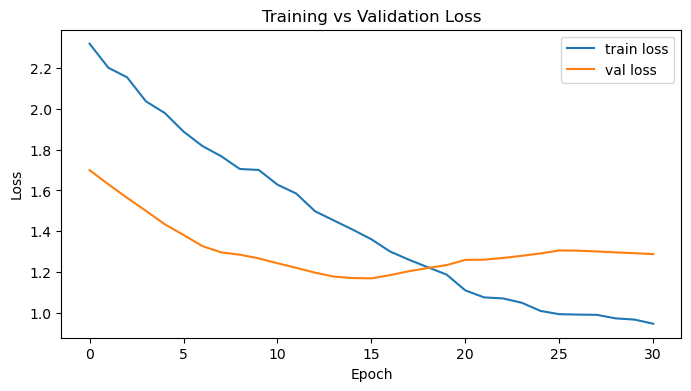

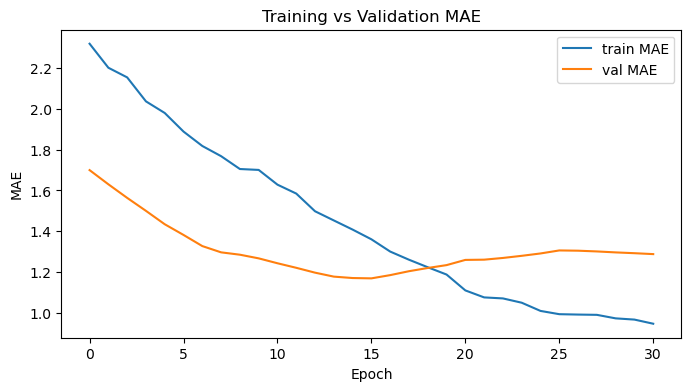

Test MSE: 20.198   Test MAE: 20.198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


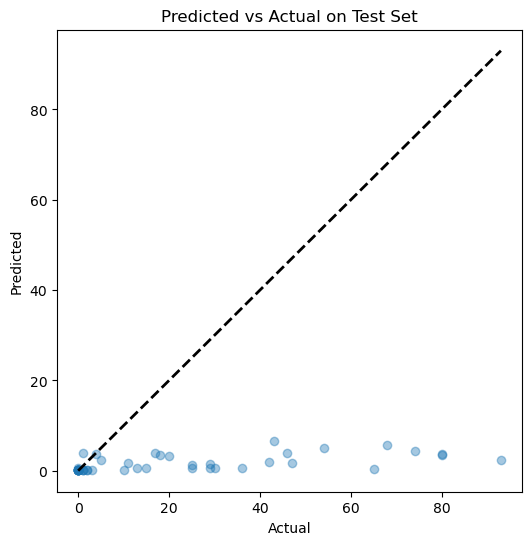

Test MAE:  20.19756317138672
R² = -0.49


In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],  label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ——— 2) Evaluate on your held-out test set ———
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.3f}   Test MAE: {test_mae:.3f}")

# ——— 3) Compare predictions vs ground truth ———
y_pred = model.predict(X_test).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual on Test Set")
plt.show()

# ——— 4) Optional: print extra metrics ———
# print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print(f"R² = {r2_score(y_test, y_pred):.2f}")


In [83]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 91299), started 0:01:17 ago. (Use '!kill 91299' to kill it.)

In [79]:
y_train_t = np.log1p(y_train)
y_test_t  = np.log1p(y_test)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(32),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train_t,
          validation_data=(X_test, y_test_t),
          epochs=300, batch_size=64,
          callbacks=[
              EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
          ])

# MAE on original scale
pred = np.expm1(model.predict(X_test).ravel())
mae  = np.mean(np.abs(pred - y_test))
print("Test MAE:", mae)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 12.5327 - mae: 3.0200 - val_loss: 6.9351 - val_mae: 2.1380 - learning_rate: 0.0010
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 11.4029 - mae: 2.8485 - val_loss: 6.0687 - val_mae: 1.9677 - learning_rate: 0.0010
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 10.0547 - mae: 2.6411 - val_loss: 5.3471 - val_mae: 1.8228 - learning_rate: 0.0010
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 8.9910 - mae: 2.4787 - val_loss: 4.7554 - val_mae: 1.7239 - learning_rate: 0.0010
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 8.1045 - mae: 2.3438 - val_loss: 4.2582 - val_mae: 1.6435 - learning_rate: 0.0010
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 7.4170 - mae: 2.2307 - val_loss: 3.8483 - val_mae: 1.5769 - learning_rate: 0.0010
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.8275 - mae: 2.1208 - val_loss: 3.4954 - val_mae: 1.5157 - learning_rate: 0.0010
Epoch 8/300
1/1 ━━━

In [80]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

timesteps, n_features = X_train.shape[1], X_train.shape[2]
y_train_t = np.log1p(y_train)
y_test_t  = np.log1p(y_test)

model = Sequential([
    Conv1D(64, kernel_size=3, padding="causal", activation=None, input_shape=(timesteps, n_features)),
    BatchNormalization(), ReLU(), Dropout(0.2),

    Conv1D(64, kernel_size=3, padding="causal", activation=None),
    BatchNormalization(), ReLU(), Dropout(0.2),

    Conv1D(32, kernel_size=3, padding="causal", activation=None),
    BatchNormalization(), ReLU(),

    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)  # linear regression head
])

model.compile(optimizer=Adam(1e-3), loss="mae", metrics=["mae"])
history = model.fit(X_train, y_train_t,  # or use log1p target if skewed
          validation_data=(X_test, y_test_t),
          epochs=200, batch_size=128,
          callbacks=[EarlyStopping(patience=15, restore_best_weights=True),
                     ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)])

# MAE on original scale
pred = np.expm1(model.predict(X_test).ravel())
mae  = np.mean(np.abs(pred - y_test_t))
print("Test MAE:", mae)

Epoch 1/200


/opt/anaconda3/envs/tf-mac/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.3192 - mae: 2.3192 - val_loss: 1.6996 - val_mae: 1.6996 - learning_rate: 0.0010
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.2014 - mae: 2.2014 - val_loss: 1.6300 - val_mae: 1.6300 - learning_rate: 0.0010
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.1541 - mae: 2.1541 - val_loss: 1.5634 - val_mae: 1.5634 - learning_rate: 0.0010
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.0366 - mae: 2.0366 - val_loss: 1.4998 - val_mae: 1.4998 - learning_rate: 0.0010
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.9796 - mae: 1.9796 - val_loss: 1.4342 - val_mae: 1.4342 - learning_rate: 0.0010
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.8885 - mae: 1.8885 - val_loss: 1.3817 - val_mae: 1.3817 - learning_rate: 0.0010
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.8179 - mae: 1.8179 - val_loss: 1.3271 - val_mae: 1.3271 - learning_rate: 0.0010
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━